### **Task 3. Pakistan Case Study**

In [2]:
# importing packages
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry
from datetime import datetime

sns.set(style="whitegrid")
custom_palette = ['#002a80', '#2c4fab', '#5974d6', '#889eec', '#bac9fe', '#ffe7c0', '#ffcf9f', '#ffb67e', '#ff9b5c', '#ff7d36']

#### Part 1. Build dataset with number of tests purchased (TGF)

Clean Transaction Summary Dataset:

In [6]:
# importing tgf transaction summary dataset - filtered for 'TB molecular diagnostics'
tgf_trans = pd.read_csv('/Users/henriquerodrigues/Desktop/LSE/Y2/Capstone/Data/Input/TGF/transaction_summary.csv', encoding='utf-16', sep='\t')
# dropping first row
tgf_trans = tgf_trans.drop(index=0)

# transforming date columns into datetime format
date_columns = ['Purchase Order Date', 'Scheduled Delivery Date', 'Actual Delivery Date']

for col in date_columns:
    # issue with date columns - 'sept' to 'sep'
    tgf_trans[col] = tgf_trans[col].str.replace('Sept', 'Sep')
    tgf_trans[col] = pd.to_datetime(tgf_trans[col], format='%d-%b-%y')

# transforming columns to numerical
cols_to_num = ['Pack quantity', 'Product pack (USD)', 'Total Product Cost (USD)']

for col in cols_to_num:
    tgf_trans[col] = tgf_trans[col].str.replace(',', '').astype(float)
    tgf_trans[col] = pd.to_numeric(tgf_trans[col], errors='coerce')

# renaming columns
tgf_trans = tgf_trans.rename(columns={"Supplier/Agent/Manufacturer/Intermediatry  ": "Supplier/Agent/Manufacturer/Intermediatry",
                                      "Manufacturer  ": "Manufacturer", 
                                      "Description ": "Description",
                                      "Freight Cost ": "Freight Cost"})

# excluding regional/multicountry observations - e.g. 'Africa', 'Americas', etc.
valid_codes = [country.alpha_3 for country in pycountry.countries]
tgf_trans['Country Code'] = tgf_trans['Grant Name'].str[:3]
tgf_trans = tgf_trans[tgf_trans['Country Code'].isin(valid_codes)]

# change product names
prod_dict = {"Cepheid Xpert MTB/XDR kit (10s) [GXMTB/XDR-10]": "Cepheid Xpert MTB/XDR",
   "Cepheid Xpert MTB/RIF kit (10s, 50s) [CGXMTBRIF]": "Cepheid Xpert MTB/RIF",
   "Cepheid Xpert MTB/RIF Ultra (50s) [GXMTB/RIF-ULTRA-50]": "Cepheid Xpert MTB/RIF Ultra",
   "Cepheid Xpert MTB/RIF Ultra (10s) [GXMTB/RIF-ULTRA-10]": "Cepheid Xpert MTB/RIF Ultra"}

tgf_trans['Description'] = tgf_trans['Description'].map(prod_dict).fillna(tgf_trans['Description'])

# creating column for number of tests in each product pack
tgf_trans['N Units in Pack'] = tgf_trans['Product Pack'].str.extract('(\d+)').astype(int)

# total number of tests per order
tgf_trans['N Units Total'] = tgf_trans['N Units in Pack'] * tgf_trans['Pack quantity']

Filtering for Pakistan:

In [8]:
# keep only Pakistan
tgf_pak = tgf_trans[tgf_trans['Country/Teritorry']=='Pakistan']

Data Analysis:

In [10]:
tgf_pak['Description'].value_counts()

Description
Cepheid Xpert MTB/RIF                                                           7
Cepheid Xpert MTB/RIF Ultra                                                     3
Cepheid GeneXpert Model GX-XVI-16 module instrument with laptop [GXXVI-16-L]    2
Cepheid GeneXpert Model GX-IV- 4 module Instrument with desktop [GXIV-4D]       1
Name: count, dtype: int64

In [15]:
pd.DataFrame(tgf_pak.groupby('Description')['N Units Total'].sum().reset_index())

,Description,N Units Total
0,Cepheid GeneXpert Model GX-IV- 4 module Instru...,39.0
1,Cepheid GeneXpert Model GX-XVI-16 module instr...,6.0
2,Cepheid Xpert MTB/RIF,881750.0
3,Cepheid Xpert MTB/RIF Ultra,170000.0


In [ ]:
# transforming date columns into datetime format
tgf_pak['Purchase Order Date'] = pd.to_datetime(tgf_trans[col], format='%y-%m-%d')

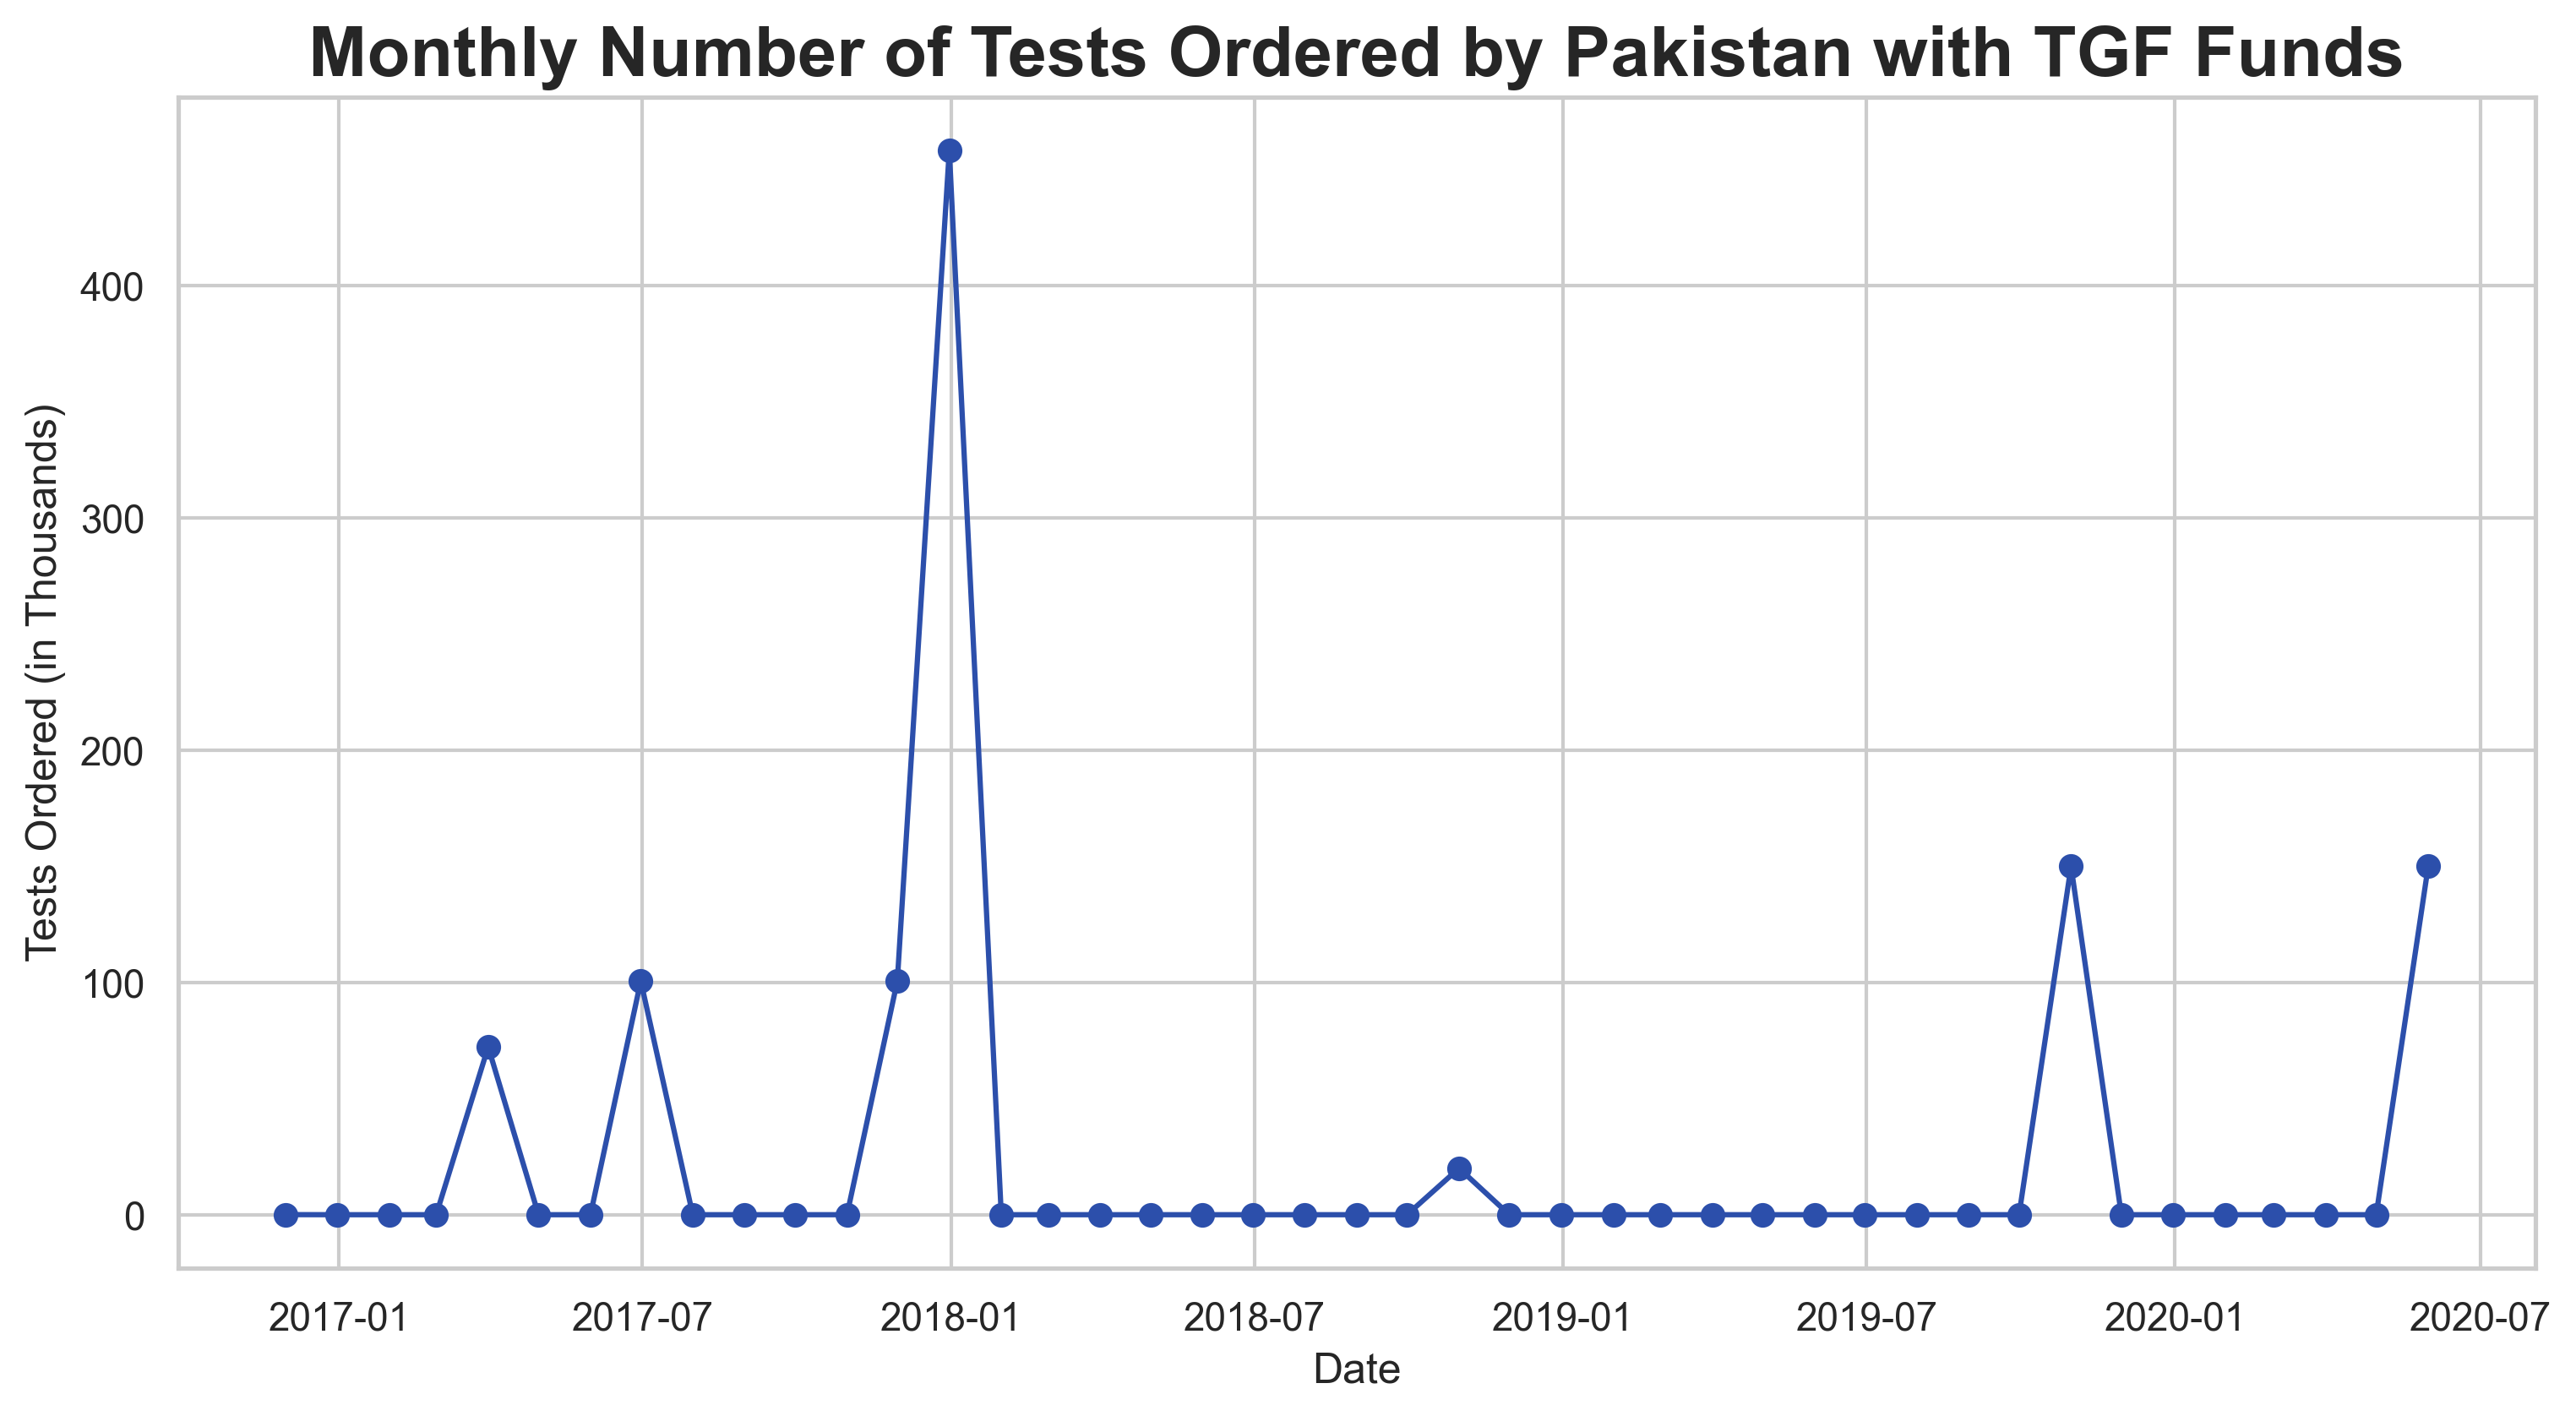

In [30]:
quart_tests = tgf_pak.set_index('Purchase Order Date')['N Units Total'].resample('M').sum()

plt.figure(figsize=(12, 6), dpi=300)
plt.plot(quart_tests.index, quart_tests/1000, marker='o', color='#2c4fab')
plt.title('Monthly Number of Tests Ordered by Pakistan with TGF Funds', fontweight='bold', fontsize=20)
plt.xlabel('Date')
plt.ylabel('Tests Ordered (in Thousands)')
plt.grid(True)
plt.show()